In [1]:
import pandas as pd
import numpy as np
import shap
import warnings
import joblib
import sys
import psutil
import GPUtil
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, GroupKFold
from collections import defaultdict
from time import time
from datetime import timedelta
from importlib.metadata import version

# printout of python version
print("="*50, "Python Version", "="*50)
print(f"python version: {sys.version}")
print(f"xgboost:        {version('xgboost')}")
print(f"shap:           {version('shap')}")

# printout of hardware
print("="*50, "Hardware", "="*50)
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}")
print(f"CPU cores: {psutil.cpu_count(logical=False)}")
print(f"RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024 :.2f} GB")

warnings.filterwarnings('ignore')

================================================== Python Version ==================================================
python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xgboost:        2.1.1
shap:           0.46.0
================================================== Hardware ==================================================
GPU: NVIDIA GeForce RTX 4090
CPU cores: 16
RAM: 63.82 GB


# read data function

In [2]:
def read_abcd(path, cols, na_values):
    
    df = pd.read_csv(path, sep='\t', index_col='subjectkey', na_values=na_values)
    df = df.drop(df.index[0])
    
    for col in cols:
        df[col] = pd.to_numeric(df[col])
        df = df[cols]

    df = df.reset_index()
    df = df.sort_values(['subjectkey', 'interview_age'])
    df = df.drop_duplicates(subset=['subjectkey'], keep='first')
    df = df.drop(columns=['interview_age'])
    df = df.set_index('subjectkey')
    
    df_show = abcd_ysu02.join(df)
    df_show = df_show.drop(columns=[
        'isip_1d_2',
        'isip_5_2',
        'isip_1b_yn'
    ])
     
    for col in df_show.columns:
        print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10.1f}'.\
              format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
    print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))
    
    return df

# y-target variable

In [3]:
file_abcd_ysu02 = r'D:\gregn\data\ABCD\abcd3\abcd_ysu02.txt'
abcd_ysu02 = pd.read_csv(file_abcd_ysu02, sep='\t', index_col='subjectkey')
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02.index[0])
cols = [
    'interview_age',
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
]

for col in cols:
    abcd_ysu02[col] = pd.to_numeric(abcd_ysu02[col])
    abcd_ysu02 = abcd_ysu02[cols]
    
abcd_ysu02 = abcd_ysu02.reset_index()
abcd_ysu02 = abcd_ysu02.sort_values(['subjectkey', 'interview_age'])
abcd_ysu02 = abcd_ysu02.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_ysu02 = abcd_ysu02.drop(columns=['interview_age'])
abcd_ysu02 = abcd_ysu02.set_index('subjectkey')
    
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 3].index) # drop accidental 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 2].index) # drop furtive 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1b_yn == 0].index) # drop religious 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1d_2 > 10].index) # drop older than 10

abcd_ysu02['isip_1d_2'] = abcd_ysu02['isip_1d_2'].fillna(0)

y = abcd_ysu02['isip_1d_2'].values
y = np.where(y>0, 1, y)

unique, counts = np.unique(y, return_counts=True)

print('number of subjects: {:>10}\n\n[0] never sipped: {:>12}\n[1] sipped by age 10:{:>9}'.\
      format(len(y), counts[0], counts[1]))

number of subjects:      10707

[0] never sipped:         9209
[1] sipped by age 10:     1498


# abcd_ksad01

In [4]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ksad01.txt'

cols = [
'interview_age',
'ksads_1_843_p',
'ksads_1_845_p',
'ksads_1_844_p',
'ksads_1_840_p',
'ksads_1_841_p',
'ksads_1_842_p',
'ksads_1_847_p',
'ksads_1_846_p',
'ksads_2_837_p',
'ksads_2_835_p',
'ksads_2_836_p',
'ksads_2_831_p',
'ksads_2_832_p',
'ksads_2_830_p',
'ksads_2_833_p',
'ksads_2_834_p',
'ksads_2_839_p',
'ksads_2_838_p',
'ksads_3_848_p',
'ksads_4_851_p',
'ksads_4_852_p',
'ksads_4_826_p',
'ksads_4_827_p',
'ksads_4_829_p',
'ksads_4_828_p',
'ksads_4_850_p',
'ksads_4_849_p',
'ksads_5_906_p',
'ksads_5_907_p',
'ksads_5_857_p',
'ksads_5_858_p',
'ksads_6_908_p',
'ksads_6_859_p',
'ksads_6_860_p',
'ksads_7_861_p',
'ksads_7_909_p',
'ksads_7_910_p',
'ksads_7_862_p',
'ksads_8_864_p',
'ksads_8_863_p',
'ksads_8_912_p',
'ksads_8_911_p',
'ksads_9_868_p',
'ksads_9_867_p',
'ksads_10_914_p',
'ksads_10_913_p',
'ksads_10_869_p',
'ksads_10_870_p',
'ksads_11_917_p',
'ksads_11_918_p',
'ksads_11_919_p',
'ksads_11_920_p',
'ksads_12_928_p',
'ksads_12_927_p',
'ksads_12_925_p',
'ksads_12_926_p',
'ksads_13_939_p',
'ksads_13_938_p',
'ksads_13_929_p',
'ksads_13_934_p',
'ksads_13_933_p',
'ksads_13_932_p',
'ksads_13_931_p',
'ksads_13_930_p',
'ksads_13_936_p',
'ksads_13_935_p',
'ksads_13_937_p',
'ksads_13_940_p',
'ksads_13_943_p',
'ksads_13_942_p',
'ksads_13_944_p',
'ksads_13_941_p',
'ksads_14_856_p',
'ksads_14_855_p',
'ksads_14_853_p',
'ksads_14_854_p',
'ksads_15_901_p',
'ksads_15_902_p',
'ksads_15_97_p',
'ksads_16_900_p',
'ksads_16_897_p',
'ksads_16_899_p',
'ksads_16_898_p',
'ksads_17_905_p',
'ksads_17_904_p',
'ksads_18_903_p',
'ksads_19_895_p',
'ksads_19_896_p',
'ksads_19_891_p',
'ksads_19_892_p',
'ksads_20_893_p',
'ksads_20_894_p',
'ksads_20_874_p',
'ksads_20_883_p',
'ksads_20_872_p',
'ksads_20_881_p',
'ksads_20_889_p',
'ksads_20_890_p',
'ksads_20_887_p',
'ksads_20_878_p',
'ksads_20_877_p',
'ksads_20_886_p',
'ksads_20_875_p',
'ksads_20_884_p',
'ksads_20_876_p',
'ksads_20_885_p',
'ksads_20_879_p',
'ksads_20_888_p',
'ksads_20_873_p',
'ksads_20_882_p',
'ksads_20_880_p',
'ksads_20_871_p',
'ksads_21_923_p',
'ksads_21_924_p',
'ksads_21_921_p',
'ksads_21_922_p',
'ksads_22_970_p',
'ksads_22_969_p',
'ksads_23_946_p',
'ksads_23_957_p',
'ksads_23_954_p',
'ksads_23_965_p',
'ksads_23_956_p',
'ksads_23_945_p',
'ksads_23_950_p',
'ksads_23_961_p',
'ksads_23_947_p',
'ksads_23_958_p',
'ksads_23_948_p',
'ksads_23_959_p',
'ksads_23_949_p',
'ksads_23_960_p',
'ksads_23_952_p',
'ksads_23_963_p',
'ksads_23_966_p',
'ksads_23_955_p',
'ksads_23_951_p',
'ksads_23_962_p',
'ksads_23_953_p',
'ksads_23_964_p',
'ksads_24_968_p',
'ksads_24_967_p',
'ksads_25_916_p',
'ksads_25_915_p',
'ksads_25_866_p',
'ksads_25_865_p',

]

na_values = ['555', '888']
abcd_ksad01 = read_abcd(path, cols, na_values)

ksads_1_843_p                     n = 10580         mean = 0.0000        sum = 0.0       
ksads_1_845_p                     n = 10580         mean = 0.0013        sum = 14.0      
ksads_1_844_p                     n = 10580         mean = 0.0000        sum = 0.0       
ksads_1_840_p                     n = 10580         mean = 0.0020        sum = 21.0      
ksads_1_841_p                     n = 10580         mean = 0.0017        sum = 18.0      
ksads_1_842_p                     n = 10580         mean = 0.0245        sum = 259.0     
ksads_1_847_p                     n = 10580         mean = 0.0353        sum = 374.0     
ksads_1_846_p                     n = 10580         mean = 0.0011        sum = 12.0      
ksads_2_837_p                     n = 10580         mean = 0.0116        sum = 123.0     
ksads_2_835_p                     n = 10580         mean = 0.0000        sum = 0.0       
ksads_2_836_p                     n = 10580         mean = 0.0006        sum = 6.0       
ksads_2_83

# abcd_ksad501

In [5]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ksad501.txt'

cols = [
'interview_age',
'ksads_4_826_t',
'ksads_4_827_t',
'ksads_4_828_t',
'ksads_4_829_t',
'ksads_2_830_t',
'ksads_2_831_t',
'ksads_2_832_t',
'ksads_2_833_t',
'ksads_2_834_t',
'ksads_2_835_t',
'ksads_2_836_t',
'ksads_2_837_t',
'ksads_2_838_t',
'ksads_2_839_t',
'ksads_1_840_t',
'ksads_1_841_t',
'ksads_1_842_t',
'ksads_1_843_t',
'ksads_1_844_t',
'ksads_1_845_t',
'ksads_1_846_t',
'ksads_1_847_t',
'ksads_3_848_t',
'ksads_4_849_t',
'ksads_4_850_t',
'ksads_4_851_t',
'ksads_4_852_t',
'ksads_14_853_t',
'ksads_14_854_t',
'ksads_14_855_t',
'ksads_14_856_t',
'ksads_5_857_t',
'ksads_5_858_t',
'ksads_6_859_t',
'ksads_6_860_t',
'ksads_7_861_t',
'ksads_7_862_t',
'ksads_8_863_t',
'ksads_8_864_t',
'ksads_25_865_t',
'ksads_25_866_t',
'ksads_9_867_t',
'ksads_9_868_t',
'ksads_10_869_t',
'ksads_10_870_t',
'ksads_20_871_t',
'ksads_20_872_t',
'ksads_20_873_t',
'ksads_20_874_t',
'ksads_20_875_t',
'ksads_20_876_t',
'ksads_20_877_t',
'ksads_20_878_t',
'ksads_20_879_t',
'ksads_20_880_t',
'ksads_20_881_t',
'ksads_20_882_t',
'ksads_20_883_t',
'ksads_20_884_t',
'ksads_20_885_t',
'ksads_20_886_t',
'ksads_20_887_t',
'ksads_20_888_t',
'ksads_20_889_t',
'ksads_20_890_t',
'ksads_19_891_t',
'ksads_19_892_t',
'ksads_20_893_t',
'ksads_20_894_t',
'ksads_19_895_t',
'ksads_19_896_t',
'ksads_16_897_t',
'ksads_16_898_t',
'ksads_16_899_t',
'ksads_16_900_t',
'ksads_15_901_t',
'ksads_15_902_t',
'ksads_18_903_t',
'ksads_17_904_t',
'ksads_17_905_t',
'ksads_5_906_t',
'ksads_5_907_t',
'ksads_6_908_t',
'ksads_7_909_t',
'ksads_7_910_t',
'ksads_8_911_t',
'ksads_8_912_t',
'ksads_10_913_t',
'ksads_10_914_t',
'ksads_25_915_t',
'ksads_25_916_t',
'ksads_11_917_t',
'ksads_11_918_t',
'ksads_11_919_t',
'ksads_11_920_t',
'ksads_21_921_t',
'ksads_21_922_t',
'ksads_21_923_t',
'ksads_21_924_t',
'ksads_12_925_t',
'ksads_12_926_t',
'ksads_12_927_t',
'ksads_12_928_t',
'ksads_13_929_t',
'ksads_13_930_t',
'ksads_13_931_t',
'ksads_13_932_t',
'ksads_13_933_t',
'ksads_13_934_t',
'ksads_13_935_t',
'ksads_13_936_t',
'ksads_13_937_t',
'ksads_13_938_t',
'ksads_13_939_t',
'ksads_13_940_t',
'ksads_13_941_t',
'ksads_13_942_t',
'ksads_13_943_t',
'ksads_13_944_t',
'ksads_23_945_t',
'ksads_23_946_t',
'ksads_23_947_t',
'ksads_23_948_t',
'ksads_23_949_t',
'ksads_23_950_t',
'ksads_23_951_t',
'ksads_23_952_t',
'ksads_23_953_t',
'ksads_23_954_t',
'ksads_23_955_t',
'ksads_23_956_t',
'ksads_23_957_t',
'ksads_23_958_t',
'ksads_23_959_t',
'ksads_23_960_t',
'ksads_23_961_t',
'ksads_23_962_t',
'ksads_23_963_t',
'ksads_23_964_t',
'ksads_23_965_t',
'ksads_23_966_t',
'ksads_24_967_t',
'ksads_24_968_t',
'ksads_22_969_t',
'ksads_22_970_t',

]

na_values = ['555']
abcd_ksad501 = read_abcd(path, cols, na_values)

ksads_4_826_t                     n = 0             mean = nan           sum = 0.0       
ksads_4_827_t                     n = 0             mean = nan           sum = 0.0       
ksads_4_828_t                     n = 0             mean = nan           sum = 0.0       
ksads_4_829_t                     n = 0             mean = nan           sum = 0.0       
ksads_2_830_t                     n = 10640         mean = 0.0023        sum = 25.0      
ksads_2_831_t                     n = 10640         mean = 0.0022        sum = 23.0      
ksads_2_832_t                     n = 10640         mean = 0.0006        sum = 6.0       
ksads_2_833_t                     n = 10640         mean = 0.0294        sum = 313.0     
ksads_2_834_t                     n = 10640         mean = 0.0028        sum = 30.0      
ksads_2_835_t                     n = 10640         mean = 0.0007        sum = 7.0       
ksads_2_836_t                     n = 10640         mean = 0.0015        sum = 16.0      
ksads_2_83

# abcd_bpmt01

In [6]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_bpmt01.txt'

cols = [
    'interview_age',
    'bpmt_q1',
    'bpmt_q2',
    'bpmt_q3',
    'bpmt_q4',
    'bpmt_q5',
    'bpmt_q6',
    'bpmt_q7',
    'bpmt_q8',
    'bpmt_q9',
    'bpmt_q10',
    'bpmt_q11',
    'bpmt_q12',
    'bpmt_q13',
    'bpmt_q14',
    'bpmt_q15',
    'bpmt_q16',
    'bpmt_q17',
    'bpmt_q18',
]

na_values = [None]
abcd_bpmt01 = read_abcd(path, cols, na_values)

bpmt_q1                           n = 4532          mean = 0.2888        sum = 1309.0    
bpmt_q2                           n = 4534          mean = 0.3449        sum = 1564.0    
bpmt_q3                           n = 4531          mean = 0.4745        sum = 2150.0    
bpmt_q4                           n = 4525          mean = 0.5534        sum = 2504.0    
bpmt_q5                           n = 4525          mean = 0.3750        sum = 1697.0    
bpmt_q6                           n = 4530          mean = 0.0669        sum = 303.0     
bpmt_q7                           n = 4523          mean = 0.2335        sum = 1056.0    
bpmt_q8                           n = 4513          mean = 0.1979        sum = 893.0     
bpmt_q9                           n = 4523          mean = 0.4245        sum = 1920.0    
bpmt_q10                          n = 4519          mean = 0.2582        sum = 1167.0    
bpmt_q11                          n = 4514          mean = 0.1019        sum = 460.0     
bpmt_q12  

# abcd_ssbpmtf01

In [7]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ssbpmtf01.txt'

cols = [
    'interview_age',
    'bpm_t_scr_attention_t',
    'bpm_t_scr_internal_t',
    'bpm_t_scr_external_t',
    'bpm_t_scr_totalprob_t'
]

na_values = [None]
abcd_ssbpmtf01 = read_abcd(path, cols, na_values)

bpm_t_scr_attention_t             n = 3567          mean = 55.2215       sum = 196975.0  
bpm_t_scr_internal_t              n = 4459          mean = 55.8636       sum = 249096.0  
bpm_t_scr_external_t              n = 4472          mean = 53.7771       sum = 240491.0  
bpm_t_scr_totalprob_t             n = 3467          mean = 55.5068       sum = 192442.0  

subjects:     10707
features:         4


# abcd_cbcls01

In [8]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_cbcls01.txt'

cols = [
    'interview_age',
    'cbcl_scr_syn_anxdep_t',
    'cbcl_scr_syn_withdep_t',
    'cbcl_scr_syn_somatic_t',
    'cbcl_scr_syn_social_t',
    'cbcl_scr_syn_thought_t',
    'cbcl_scr_syn_attention_t',
    'cbcl_scr_syn_rulebreak_t',
    'cbcl_scr_syn_aggressive_t',
    'cbcl_scr_syn_internal_t',
    'cbcl_scr_syn_external_t',
    'cbcl_scr_syn_totprob_t',
    'cbcl_scr_dsm5_depress_t',
    'cbcl_scr_dsm5_anxdisord_t',
    'cbcl_scr_dsm5_somaticpr_t',
    'cbcl_scr_dsm5_adhd_t',
    'cbcl_scr_dsm5_opposit_t',
    'cbcl_scr_dsm5_conduct_t',
    'cbcl_scr_07_sct_t',
    'cbcl_scr_07_ocd_t',
    'cbcl_scr_07_stress_t'  
]

na_values = [None]
abcd_cbcls01 = read_abcd(path, cols, na_values)

cbcl_scr_syn_anxdep_t             n = 10699         mean = 53.5015       sum = 572413.0  
cbcl_scr_syn_withdep_t            n = 10699         mean = 53.5715       sum = 573162.0  
cbcl_scr_syn_somatic_t            n = 10699         mean = 54.8586       sum = 586932.0  
cbcl_scr_syn_social_t             n = 10699         mean = 52.7910       sum = 564811.0  
cbcl_scr_syn_thought_t            n = 10699         mean = 53.7925       sum = 575526.0  
cbcl_scr_syn_attention_t          n = 10699         mean = 53.8612       sum = 576261.0  
cbcl_scr_syn_rulebreak_t          n = 10699         mean = 52.7507       sum = 564380.0  
cbcl_scr_syn_aggressive_t         n = 10699         mean = 52.8117       sum = 565032.0  
cbcl_scr_syn_internal_t           n = 10699         mean = 48.4666       sum = 518544.0  
cbcl_scr_syn_external_t           n = 10699         mean = 45.6474       sum = 488382.0  
cbcl_scr_syn_totprob_t            n = 10699         mean = 45.7977       sum = 489990.0  
cbcl_scr_d

# abcd_mhy02

In [9]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_mhy02.txt'

cols = [
    'interview_age',
    'pps_y_ss_number',
    'pps_y_ss_bother_sum',
    'pps_y_ss_severity_score'
]

na_values = [None]
abcd_mhy02 = read_abcd(path, cols, na_values)

pps_y_ss_number                   n = 10696         mean = 2.5757        sum = 27550.0   
pps_y_ss_bother_sum               n = 6498          mean = 2.1076        sum = 13695.0   
pps_y_ss_severity_score           n = 10697         mean = 6.1583        sum = 65875.0   

subjects:     10707
features:         3


# abcd_pksadscd01

In [10]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_pksadscd01.txt'

cols = [
"interview_age",
"ksads_cdr_466_p",
"ksads_cdr_467_p",
"ksads_cdr_468_p",
"ksads_cdr_469_p",
"ksads_cdr_470_p",
"ksads_cdr_471_p",
"ksads_cdr_472_p",
"ksads_cdr_473_p",
"ksads_cdr_474_p",
"ksads_cdr_475_p",
"ksads_cdr_476_p",
"ksads_cdr_477_p",
"ksads_cdr_478_p",
"ksads_cdr_479_p",
"ksads_cdr_480_p",
"ksads_cdr_481_p",
"ksads_cdr_482_p",
"ksads_cdr_483_p",
"ksads_cdr_1044_p",
"ksads_cdr_1045_p",
"ksads_cdr_1046_p",
"ksads_cdr_1047_p",
"ksads_cdr_1048_p",
"ksads_cdr_1049_p",
"ksads_cdr_1050_p",
"ksads_cdr_1051_p",
"ksads_cdr_1052_p",
"ksads_cdr_1053_p",
"ksads_cdr_1054_p",
"ksads_cdr_1055_p",
"ksads_cdr_1056_p",
"ksads_cdr_1057_p",
"ksads_cdr_1058_p",
"ksads_cdr_1059_p",
"ksads_cdr_1060_p",
"ksads_cdr_1061_p",
"ksads_cdr_1062_p",
"ksads_cdr_1063_p",
"ksads_cdr_1064_p",
"ksads_cdr_1065_p",
"ksads_cdr_1066_p",
"ksads_cdr_1067_p",
"ksads_cdr_1068_p",
"ksads_cdr_1069_p",
"ksads_cdr_1070_p",
"ksads_cdr_1071_p",
"ksads_cdr_1072_p",
"ksads_cdr_1073_p",
"ksads_cdr_1074_p",
"ksads_cdr_1075_p",
"ksads_cdr_1076_p___3rd",
"ksads_cdr_1076_p___4th",
"ksads_cdr_1076_p___5th",
"ksads_cdr_1076_p___6th",
"ksads_cdr_1076_p___7th",
"ksads_cdr_1076_p___8th",
"ksads_cdr_1076_p___9th",
"ksads_cdr_1076_p___10th",
"ksads_cdr_1076_p___11th",
"ksads_cdr_1076_p___12th",
"ksads_cdr_1077_p___3rd",
"ksads_cdr_1077_p___4th",
"ksads_cdr_1077_p___5th",
"ksads_cdr_1077_p___6th",
"ksads_cdr_1077_p___7th",
"ksads_cdr_1077_p___8th",
"ksads_cdr_1077_p___9th",
"ksads_cdr_1077_p___10th",
"ksads_cdr_1077_p___11th",
"ksads_cdr_1077_p___12th",
"ksads_cdr_1078_p___3rd",
"ksads_cdr_1078_p___4th",
"ksads_cdr_1078_p___5th",
"ksads_cdr_1078_p___6th",
"ksads_cdr_1078_p___7th",
"ksads_cdr_1078_p___8th",
"ksads_cdr_1078_p___9th",
"ksads_cdr_1078_p___10th",
"ksads_cdr_1078_p___11th",
"ksads_cdr_1078_p___12th",
"ksads_cdr_1079_p___3rd",
"ksads_cdr_1079_p___4th",
"ksads_cdr_1079_p___5th",
"ksads_cdr_1079_p___6th",
"ksads_cdr_1079_p___7th",
"ksads_cdr_1079_p___8th",
"ksads_cdr_1079_p___9th",
"ksads_cdr_1079_p___10th",
"ksads_cdr_1079_p___11th",
"ksads_cdr_1079_p___12th",
"ksads_cdr_1080_p___3rd",
"ksads_cdr_1080_p___4th",
"ksads_cdr_1080_p___5th",
"ksads_cdr_1080_p___6th",
"ksads_cdr_1080_p___7th",
"ksads_cdr_1080_p___8th",
"ksads_cdr_1080_p___9th",
"ksads_cdr_1080_p___10th",
"ksads_cdr_1080_p___11th",
"ksads_cdr_1080_p___12th",
"ksads_cdr_1081_p___3rd",
"ksads_cdr_1081_p___4th",
"ksads_cdr_1081_p___5th",
"ksads_cdr_1081_p___6th",
"ksads_cdr_1081_p___7th",
"ksads_cdr_1081_p___8th",
"ksads_cdr_1081_p___9th",
"ksads_cdr_1081_p___10th",
"ksads_cdr_1081_p___11th",
"ksads_cdr_1081_p___12th",
"ksads_cdr_1082_p___3rd",
"ksads_cdr_1082_p___4th",
"ksads_cdr_1082_p___5th",
"ksads_cdr_1082_p___6th",
"ksads_cdr_1082_p___7th",
"ksads_cdr_1082_p___8th",
"ksads_cdr_1082_p___9th",
"ksads_cdr_1082_p___10th",
"ksads_cdr_1082_p___11th",
"ksads_cdr_1082_p___12th",
"ksads_cdr_1083_p___3rd",
"ksads_cdr_1083_p___4th",
"ksads_cdr_1083_p___5th",
"ksads_cdr_1083_p___6th",
"ksads_cdr_1083_p___7th",
"ksads_cdr_1083_p___8th",
"ksads_cdr_1083_p___9th",
"ksads_cdr_1083_p___10th",
"ksads_cdr_1083_p___11th",
"ksads_cdr_1083_p___12th",
"ksads_cdr_1084_p___3rd",
"ksads_cdr_1084_p___4th",
"ksads_cdr_1084_p___5th",
"ksads_cdr_1084_p___6th",
"ksads_cdr_1084_p___7th",
"ksads_cdr_1084_p___8th",
"ksads_cdr_1084_p___9th",
"ksads_cdr_1084_p___10th",
"ksads_cdr_1084_p___11th",
"ksads_cdr_1084_p___12th",
"ksads_cdr_1085_p___3rd",
"ksads_cdr_1085_p___4th",
"ksads_cdr_1085_p___5th",
"ksads_cdr_1085_p___6th",
"ksads_cdr_1085_p___7th",
"ksads_cdr_1085_p___8th",
"ksads_cdr_1085_p___9th",
"ksads_cdr_1085_p___10th",
"ksads_cdr_1085_p___11th",
"ksads_cdr_1085_p___12th",
"ksads_cdr_1086_p___3rd",
"ksads_cdr_1086_p___4th",
"ksads_cdr_1086_p___5th",
"ksads_cdr_1086_p___6th",
"ksads_cdr_1086_p___7th",
"ksads_cdr_1086_p___8th",
"ksads_cdr_1086_p___9th",
"ksads_cdr_1086_p___10th",
"ksads_cdr_1086_p___11th",
"ksads_cdr_1086_p___12th",
"ksads_cdr_1087_p___3rd",
"ksads_cdr_1087_p___4th",
"ksads_cdr_1087_p___5th",
"ksads_cdr_1087_p___6th",
"ksads_cdr_1087_p___7th",
"ksads_cdr_1087_p___8th",
"ksads_cdr_1087_p___9th",
"ksads_cdr_1087_p___10th",
"ksads_cdr_1087_p___11th",
"ksads_cdr_1087_p___12th",
"ksads_cdr_1088_p___3rd",
"ksads_cdr_1088_p___4th",
"ksads_cdr_1088_p___5th",
"ksads_cdr_1088_p___6th",
"ksads_cdr_1088_p___7th",
"ksads_cdr_1088_p___8th",
"ksads_cdr_1088_p___9th",
"ksads_cdr_1088_p___10th",
"ksads_cdr_1088_p___11th",
"ksads_cdr_1088_p___12th",
"ksads_cdr_1089_p___3rd",
"ksads_cdr_1089_p___4th",
"ksads_cdr_1089_p___5th",
"ksads_cdr_1089_p___6th",
"ksads_cdr_1089_p___7th",
"ksads_cdr_1089_p___8th",
"ksads_cdr_1089_p___9th",
"ksads_cdr_1089_p___10th",
"ksads_cdr_1089_p___11th",
"ksads_cdr_1089_p___12th",
"ksads_cdr_1091_p",
"ksads_cdr_1092_p",
"ksads_cdr_1093_p",
"ksads_cdr_1094_p",
"ksads_cdr_1095_p",
"ksads_cdr_1096_p",
"ksads_cdr_1097_p",
"ksads_cdr_1098_p",
"ksads_cdr_1099_p",
"ksads_cdr_1100_p",
"ksads_cdr_1101_p",
"ksads_cdr_1102_p",
"ksads_cdr_1090_p___3rd",
"ksads_cdr_1090_p___4th",
"ksads_cdr_1090_p___5th",
"ksads_cdr_1090_p___6th",
"ksads_cdr_1090_p___7th",
"ksads_cdr_1090_p___8th",
"ksads_cdr_1090_p___9th",
"ksads_cdr_1090_p___10th",
"ksads_cdr_1090_p___11th",
"ksads_cdr_1090_p___12th",
]

na_values = [None]
abcd_pksadscd01 = read_abcd(path, cols, na_values)

ksads_cdr_466_p                   n = 10299         mean = 0.3142        sum = 3236.0    
ksads_cdr_467_p                   n = 9774          mean = 0.1387        sum = 1356.0    
ksads_cdr_468_p                   n = 529           mean = 0.7713        sum = 408.0     
ksads_cdr_469_p                   n = 10299         mean = 0.0033        sum = 34.0      
ksads_cdr_470_p                   n = 10278         mean = 0.0024        sum = 25.0      
ksads_cdr_471_p                   n = 22            mean = 0.3182        sum = 7.0       
ksads_cdr_472_p                   n = 47            mean = 7.7234        sum = 363.0     
ksads_cdr_473_p                   n = 10299         mean = 0.1518        sum = 1563.0    
ksads_cdr_474_p                   n = 328           mean = 0.5579        sum = 183.0     
ksads_cdr_475_p                   n = 9973          mean = 0.0394        sum = 393.0     
ksads_cdr_476_p                   n = 328           mean = 0.2713        sum = 89.0      
ksads_cdr_

# abcd_yksad01

In [11]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_yksad01.txt'

cols = [
'interview_age',
'kbi_y_grade_repeat',
'kbi_y_drop_in_grades',
'kbi_y_det_susp',
'kbi_y_det_reason___1',
'kbi_y_det_reason___2',
'kbi_y_det_reason___3',
'kbi_y_det_reason___4',
'kbi_y_det_reason___5',
'kbi_y_det_reason___6',
'kbi_y_det_reason___7',
'kbi_y_det_reason___8',
'kbi_y_sex_orient',
'kbi_y_sex_orient_probs',
'kbi_y_trans_id',
'kbi_y_trans_prob',
'ksads_bully_raw_26',
'kbi_y_det_reason___777',
]

na_values = ['4', '777']
abcd_yksad01 = read_abcd(path, cols, na_values)

kbi_y_grade_repeat                n = 10694         mean = 0.0751        sum = 803.0     
kbi_y_drop_in_grades              n = 10691         mean = 0.1474        sum = 1576.0    
kbi_y_det_susp                    n = 10691         mean = 0.0923        sum = 987.0     
kbi_y_det_reason___1              n = 10707         mean = 0.0436        sum = 467.0     
kbi_y_det_reason___2              n = 10707         mean = 0.0167        sum = 179.0     
kbi_y_det_reason___3              n = 10707         mean = 0.0016        sum = 17.0      
kbi_y_det_reason___4              n = 10707         mean = 0.0017        sum = 18.0      
kbi_y_det_reason___5              n = 10707         mean = 0.0002        sum = 2.0       
kbi_y_det_reason___6              n = 10707         mean = 0.0001        sum = 1.0       
kbi_y_det_reason___7              n = 10707         mean = 0.0013        sum = 14.0      
kbi_y_det_reason___8              n = 10707         mean = 0.0416        sum = 445.0     
kbi_y_sex_

# abcd_sds01

In [12]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_sds01.txt'

cols = [
    'interview_age',
    'sleepdisturb1_p',
    'sleepdisturb2_p',
    'sleepdisturb3_p',
    'sleepdisturb4_p',
    'sleepdisturb5_p',
    'sleepdisturb6_p',
    'sleepdisturb7_p',
    'sleepdisturb8_p',
    'sleepdisturb9_p',
    'sleepdisturb10_p',
    'sleepdisturb11_p',
    'sleepdisturb12_p',
    'sleepdisturb13_p',
    'sleepdisturb14_p',
    'sleepdisturb15_p',
    'sleepdisturb16_p',
    'sleepdisturb17_p',
    'sleepdisturb18_p',
    'sleepdisturb19_p',
    'sleepdisturb20_p',
    'sleepdisturb21_p',
    'sleepdisturb22_p',
    'sleepdisturb23_p',
    'sleepdisturb24_p',
    'sleepdisturb25_p',
    'sleepdisturb26_p'
]

na_values = [None]
abcd_sds01 = read_abcd(path, cols, na_values)

sleepdisturb1_p                   n = 10702         mean = 1.7220        sum = 18429.0   
sleepdisturb2_p                   n = 10702         mean = 1.9407        sum = 20769.0   
sleepdisturb3_p                   n = 10702         mean = 2.2657        sum = 24248.0   
sleepdisturb4_p                   n = 10702         mean = 1.8884        sum = 20210.0   
sleepdisturb5_p                   n = 10702         mean = 1.3483        sum = 14430.0   
sleepdisturb6_p                   n = 10702         mean = 1.2828        sum = 13729.0   
sleepdisturb7_p                   n = 10676         mean = 1.0557        sum = 11271.0   
sleepdisturb8_p                   n = 10702         mean = 1.2604        sum = 13489.0   
sleepdisturb9_p                   n = 10702         mean = 1.1749        sum = 12574.0   
sleepdisturb10_p                  n = 10702         mean = 1.3299        sum = 14233.0   
sleepdisturb11_p                  n = 10702         mean = 1.2681        sum = 13571.0   
sleepdistu

# abcd_pgbi01

In [13]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_pgbi01.txt'

cols = [
    'interview_age',
    'gen_child_behav_1',
    'gen_child_behav_2',
    'gen_child_behav_3',
    'gen_child_behav_4',
    'gen_child_behav_5',
    'gen_child_behav_6',
    'gen_child_behav_7',
    'gen_child_behav_8',
    'gen_child_behav_9',
    'gen_child_behav_10'
]

na_values = [None]
abcd_pgbi01 = read_abcd(path, cols, na_values)

gen_child_behav_1                 n = 10703         mean = 0.1746        sum = 1869.0    
gen_child_behav_2                 n = 10703         mean = 0.0537        sum = 575.0     
gen_child_behav_3                 n = 10702         mean = 0.2224        sum = 2380.0    
gen_child_behav_4                 n = 10702         mean = 0.0733        sum = 784.0     
gen_child_behav_5                 n = 10702         mean = 0.0711        sum = 761.0     
gen_child_behav_6                 n = 10702         mean = 0.1322        sum = 1415.0    
gen_child_behav_7                 n = 10700         mean = 0.1753        sum = 1876.0    
gen_child_behav_8                 n = 10700         mean = 0.0853        sum = 913.0     
gen_child_behav_9                 n = 10700         mean = 0.1228        sum = 1314.0    
gen_child_behav_10                n = 10702         mean = 0.1912        sum = 2046.0    

subjects:     10707
features:        10


# abcd_ssphp01

In [14]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ssphp01.txt'

cols = [
'interview_age',
'sds_p_ss_dims',
'sds_p_ss_sbd',
'sds_p_ss_da',
'sds_p_ss_swtd',
'sds_p_ss_does',
'sds_p_ss_shy',
'sds_p_ss_total',
'pds_p_ss_male_category',
'pds_p_ss_female_category',
'cna_p_ss_sum',
'pds_p_ss_female_category_2',
'pds_p_ss_male_category_2',
]

na_values = [None]
abcd_ssphp01 = read_abcd(path, cols, na_values)

sds_p_ss_dims                     n = 10702         mean = 11.7632       sum = 125890.0  
sds_p_ss_sbd                      n = 10702         mean = 3.7812        sum = 40466.0   
sds_p_ss_da                       n = 10702         mean = 3.4403        sum = 36818.0   
sds_p_ss_swtd                     n = 10676         mean = 8.1748        sum = 87274.0   
sds_p_ss_does                     n = 10701         mean = 6.9447        sum = 74315.0   
sds_p_ss_shy                      n = 10702         mean = 2.4369        sum = 26080.0   
sds_p_ss_total                    n = 10675         mean = 36.5415       sum = 390080.0  
pds_p_ss_male_category            n = 5336          mean = 1.3690        sum = 7305.0    
pds_p_ss_female_category          n = 4971          mean = 2.1802        sum = 10838.0   
cna_p_ss_sum                      n = 0             mean = nan           sum = 0.0       
pds_p_ss_female_category_2        n = 4944          mean = 2.1816        sum = 10786.0   
pds_p_ss_m

# abcd_ssphy01

In [15]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ssphy01.txt'

cols = [
    'interview_age',
    'pds_y_ss_male_category',
    'pds_y_ss_female_category',
    'pds_y_ss_female_category_2',
    'pds_y_ss_male_cat_2'
]

na_values = [None]
abcd_ssphy01 = read_abcd(path, cols, na_values)

pds_y_ss_male_category            n = 4940          mean = 1.9484        sum = 9625.0    
pds_y_ss_female_category          n = 3675          mean = 2.2493        sum = 8266.0    
pds_y_ss_female_category_2        n = 3669          mean = 2.2480        sum = 8248.0    
pds_y_ss_male_cat_2               n = 4914          mean = 1.9459        sum = 9562.0    

subjects:     10707
features:         4


# abcd_ant01

In [16]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ant01.txt'

cols = [
    'interview_age',
    'anthroheightcalc',
    'anthroweightcalc',
    'anthro_waist_cm'
]

na_values = [None]
abcd_ant01 = read_abcd(path, cols, na_values)

anthroheightcalc                  n = 10698         mean = 55.2152       sum = 590692.2  
anthroweightcalc                  n = 10697         mean = 82.5234       sum = 882752.7  
anthro_waist_cm                   n = 10690         mean = 26.4891       sum = 283168.4  

subjects:     10707
features:         3


# abcd_hsss01

In [17]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_hsss01.txt'

cols = [
    'interview_age',
    'hormone_scr_dhea_mean',
    'hormone_scr_hse_mean',
    'hormone_scr_ert_mean'

]

na_values = [None]
abcd_hsss01 = read_abcd(path, cols, na_values)

hormone_scr_dhea_mean             n = 9855          mean = 64.2320       sum = 633006.3  
hormone_scr_hse_mean              n = 4628          mean = 1.0425        sum = 4824.7    
hormone_scr_ert_mean              n = 9938          mean = 34.0606       sum = 338493.9  

subjects:     10707
features:         3


# abcd_yrb01

In [18]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_yrb01.txt'

cols = [
    'interview_age',
    'physical_activity1_y',
    'physical_activity2_y',
    'physical_activity5_y',
]

na_values = [None]
abcd_yrb01 = read_abcd(path, cols, na_values)

physical_activity1_y              n = 10681         mean = 3.4722        sum = 37087.0   
physical_activity2_y              n = 10677         mean = 2.9425        sum = 31417.0   
physical_activity5_y              n = 10678         mean = 2.1159        sum = 22594.0   

subjects:     10707
features:         3


# abcd_medhxss01

In [19]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_medhxss01.txt'

cols = [
'interview_age',
'medhx_ss_4b_p',
'medhx_ss_5b_p',
'medhx_ss_6a_times_p',
'medhx_ss_6b_times_p',
'medhx_ss_6c_times_p',
'medhx_ss_6d_times_p',
'medhx_ss_6e_times_p',
'medhx_ss_6f_times_p',
'medhx_ss_6g_times_p',
'medhx_ss_6h_times_p',
'medhx_ss_6i_times_p',
'medhx_ss_6j_times_p',
'medhx_ss_6k_times_p',
'medhx_ss_6l_times_p',
'medhx_ss_6m_times_p',
'medhx_ss_6n_times_p',
'medhx_ss_6o_times_p',
'medhx_ss_6p_times_p',
'medhx_ss_6q_times_p',
'medhx_ss_6r_times_p',
'medhx_ss_6s_times_p',
'medhx_ss_9b_p',
'medhx_ss_6t_times_p',

]

na_values = ['0', '999']
abcd_medhxss01 = read_abcd(path, cols, na_values)

medhx_ss_4b_p                     n = 1618          mean = 1.3745        sum = 2224.0    
medhx_ss_5b_p                     n = 5757          mean = 1.8390        sum = 10587.0   
medhx_ss_6a_times_p               n = 1504          mean = 1.2247        sum = 1842.0    
medhx_ss_6b_times_p               n = 1001          mean = 1.3097        sum = 1311.0    
medhx_ss_6c_times_p               n = 1358          mean = 1.9904        sum = 2703.0    
medhx_ss_6d_times_p               n = 1965          mean = 1.2366        sum = 2430.0    
medhx_ss_6e_times_p               n = 442           mean = 1.2760        sum = 564.0     
medhx_ss_6f_times_p               n = 1525          mean = 1.7108        sum = 2609.0    
medhx_ss_6g_times_p               n = 242           mean = 1.1364        sum = 275.0     
medhx_ss_6h_times_p               n = 2758          mean = 2.2937        sum = 6326.0    
medhx_ss_6i_times_p               n = 986           mean = 1.1572        sum = 1141.0    
medhx_ss_6

# abcd_ypdms01

In [20]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ypdms01.txt'

cols = [
    'interview_age',
    'pds_ht2_y',
    'pds_skin2_y',
    'pds_bdyhair_y',
    'pds_f4_2_y',
    'pds_f5_y',
    'pds_f6_y',
    'pds_f6_y_dk',
    'pds_m4_y',
    'pds_m5_y',
    'menstrualcycle2_y',
    'menstrualcycle2_y_dk',
    'menstrualcycle3_y',
    'menstrualcycle4_y',
    'menstrualcycle5_y',
    'menstrualcycle6_y',
]

na_values =['777', '999']
abcd_ypdms01 = read_abcd(path, cols, na_values)

pds_ht2_y                         n = 6588          mean = 2.4021        sum = 15825.0   
pds_skin2_y                       n = 9179          mean = 1.5930        sum = 14622.0   
pds_bdyhair_y                     n = 10078         mean = 1.7292        sum = 17427.0   
pds_f4_2_y                        n = 4155          mean = 1.8298        sum = 7603.0    
pds_f5_y                          n = 4552          mean = 1.0923        sum = 4972.0    
pds_f6_y                          n = 131           mean = 9.4504        sum = 1238.0    
pds_f6_y_dk                       n = 0             mean = nan           sum = 0.0       
pds_m4_y                          n = 5238          mean = 1.5871        sum = 8313.0    
pds_m5_y                          n = 5272          mean = 1.2485        sum = 6582.0    
menstrualcycle2_y                 n = 45            mean = 28.8000       sum = 1296.0    
menstrualcycle2_y_dk              n = 0             mean = nan           sum = 0.0       
menstrualc

# acspsw03

In [21]:
path = r'D:\gregn\data\ABCD\abcd3\acspsw03.txt'

cols = [
    'interview_age',
    'rel_family_id'
]

na_values = [None]
acspsw03 = read_abcd(path, cols, na_values)

rel_family_id                     n = 10707         mean = 5921.1416     sum = 63397663.0

subjects:     10707
features:         1


# join dataframes

In [22]:
dfs = [
    abcd_ysu02,
    abcd_ksad01,
    abcd_ksad501,
    abcd_bpmt01,
    abcd_ssbpmtf01,
    abcd_cbcls01,
    abcd_mhy02,
    abcd_pksadscd01,
    abcd_yksad01,
    abcd_sds01,
    abcd_pgbi01,
    abcd_ssphp01,
    abcd_ssphy01,
    abcd_ant01,
    abcd_hsss01,
    abcd_yrb01,
    abcd_medhxss01,
    abcd_ypdms01,
    acspsw03,
]

abcd = dfs[0].join(dfs[1:])
print('number of subjects:', len(abcd))

number of subjects: 10707


# drop features with fewer than 10 subjects

In [23]:
fewer10 = [col for col in abcd.columns if abcd[col].sum() < 10]
print(f"number of features with fewer than 10 subjects: {len(fewer10)}")
fewer10

number of features with fewer than 10 subjects: 305


['ksads_1_843_p',
 'ksads_1_844_p',
 'ksads_2_835_p',
 'ksads_2_836_p',
 'ksads_2_832_p',
 'ksads_3_848_p',
 'ksads_5_857_p',
 'ksads_6_908_p',
 'ksads_8_911_p',
 'ksads_12_928_p',
 'ksads_12_927_p',
 'ksads_12_925_p',
 'ksads_12_926_p',
 'ksads_13_939_p',
 'ksads_13_929_p',
 'ksads_13_934_p',
 'ksads_13_933_p',
 'ksads_13_932_p',
 'ksads_13_931_p',
 'ksads_13_930_p',
 'ksads_13_936_p',
 'ksads_13_935_p',
 'ksads_13_937_p',
 'ksads_13_943_p',
 'ksads_17_905_p',
 'ksads_17_904_p',
 'ksads_19_895_p',
 'ksads_19_896_p',
 'ksads_19_891_p',
 'ksads_19_892_p',
 'ksads_20_894_p',
 'ksads_20_874_p',
 'ksads_20_883_p',
 'ksads_20_872_p',
 'ksads_20_881_p',
 'ksads_20_889_p',
 'ksads_20_890_p',
 'ksads_20_887_p',
 'ksads_20_878_p',
 'ksads_20_877_p',
 'ksads_20_886_p',
 'ksads_20_875_p',
 'ksads_20_884_p',
 'ksads_20_876_p',
 'ksads_20_885_p',
 'ksads_20_879_p',
 'ksads_20_888_p',
 'ksads_20_873_p',
 'ksads_20_882_p',
 'ksads_20_880_p',
 'ksads_20_871_p',
 'ksads_23_954_p',
 'ksads_23_950_p',
 '

# X features 

In [24]:
X = abcd.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn',
    'rel_family_id'
])

X = X.drop(fewer10, axis=1)
X.to_csv('X_features_health.csv')
X_values = X.values
print('number of features:', X.shape[1])
list(X.columns)

number of features: 359


['ksads_1_845_p',
 'ksads_1_840_p',
 'ksads_1_841_p',
 'ksads_1_842_p',
 'ksads_1_847_p',
 'ksads_1_846_p',
 'ksads_2_837_p',
 'ksads_2_831_p',
 'ksads_2_830_p',
 'ksads_2_833_p',
 'ksads_2_834_p',
 'ksads_2_839_p',
 'ksads_2_838_p',
 'ksads_4_851_p',
 'ksads_4_852_p',
 'ksads_4_826_p',
 'ksads_4_827_p',
 'ksads_4_829_p',
 'ksads_4_828_p',
 'ksads_4_850_p',
 'ksads_4_849_p',
 'ksads_5_906_p',
 'ksads_5_907_p',
 'ksads_5_858_p',
 'ksads_6_859_p',
 'ksads_6_860_p',
 'ksads_7_861_p',
 'ksads_7_909_p',
 'ksads_7_910_p',
 'ksads_7_862_p',
 'ksads_8_864_p',
 'ksads_8_863_p',
 'ksads_8_912_p',
 'ksads_9_868_p',
 'ksads_9_867_p',
 'ksads_10_914_p',
 'ksads_10_913_p',
 'ksads_10_869_p',
 'ksads_10_870_p',
 'ksads_11_917_p',
 'ksads_11_918_p',
 'ksads_11_919_p',
 'ksads_11_920_p',
 'ksads_13_938_p',
 'ksads_13_940_p',
 'ksads_13_942_p',
 'ksads_13_944_p',
 'ksads_13_941_p',
 'ksads_14_856_p',
 'ksads_14_855_p',
 'ksads_14_853_p',
 'ksads_14_854_p',
 'ksads_15_901_p',
 'ksads_15_902_p',
 'ksads_1

# family groups

In [25]:
d = defaultdict(lambda: len(d))
family_groups = [d[x] for x in abcd['rel_family_id']]
family_groups = np.array(family_groups)
print(f"there are {len(np.unique(family_groups))} unique family groups")

there are 9011 unique family groups


# XGBoost: 5x5 nested cross validation

In [26]:
start_time = time()

model = XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state = 42, 
)

# hyperparameter grid
params = {
    'learning_rate': [0.005, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500],
    'colsample_bytree': [0.4, 0.8]
}

# inner loop 
inner_cv = GroupKFold(n_splits=5)
inner_cv = inner_cv.get_n_splits(X_values, y, groups=family_groups)

# outer loop
outer_cv = GroupKFold(n_splits=5)
outer_cv = outer_cv.get_n_splits(X_values, y, groups=family_groups)
  
# inner loop grid search
gs = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    scoring='roc_auc', 
    cv=inner_cv,
    return_train_score=True,
    verbose=3
)
gs.fit(X_values, y)

# multiple metrics 
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# outer loop scores 
nested_scores = cross_validate(
    gs,
    X=X_values, 
    y=y, 
    scoring=scoring, 
    cv=outer_cv,
)

auc = nested_scores['test_roc_auc']
acc = nested_scores['test_accuracy']
precision = nested_scores['test_precision']
recall = nested_scores['test_recall']
f1 = nested_scores['test_f1']
print('='*120)
print('\nRuntime:', str(timedelta(seconds=time()-start_time)))
print()
print(f'Average ROC AUC score:      {auc.mean():.4f} {auc}')
print(f'Average accuracy score:     {acc.mean():.4f} {acc}')
print(f'Average precision score:    {precision.mean():.4f} {precision}')
print(f'Average recall score:       {recall.mean():.4f} {recall}')
print(f'Average F1 score:           {f1.mean():.4f} {f1}')
print('\nBest parameters:\n', gs.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.729, test=0.666) total time=   0.3s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.736, test=0.669) total time=   0.2s
[CV 3/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.730, test=0.636) total time=   0.2s
[CV 4/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.733, test=0.634) total time=   0.2s
[CV 5/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.731, test=0.682) total time=   0.2s
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.790, test=0.677) total time=   0.7s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.

In [27]:
joblib.dump(gs, 'health_gridsearch.pkl')
joblib.dump(nested_scores, 'health_nested_scores.pkl')

['health_nested_scores.pkl']

# SHAP (SHapley Additive exPlanations)

In [28]:
explainer = shap.Explainer(gs.best_estimator_)
shap_values = explainer(X)

# SHAP ranking of top model features

In [29]:
# Create SHAP ranking dataframe
sv_mean = np.abs(shap_values.values).mean(0)
sv_rank = pd.DataFrame(list(zip(X, sv_mean)), columns=['feature', 'mean absolute SHAP value'])
sv_rank = sv_rank.sort_values(by='mean absolute SHAP value', ascending=False)
sv_rank['percent importance'] = sv_rank['mean absolute SHAP value'] / sv_rank['mean absolute SHAP value'].sum()*100
sv_rank['cumulative importance (%)'] = sv_rank['percent importance'].cumsum()
sv_rank.reset_index(inplace=True, drop=True)

print(f"Sum of SHAP values: {sv_rank['mean absolute SHAP value'].sum()}")
sv_rank[:20]

Sum of SHAP values: 2.2883524894714355


,feature,mean absolute SHAP value,percent importance,cumulative importance (%)
0,sleepdisturb1_p,0.167313,7.311523,7.311523
1,kbi_y_trans_id,0.134524,5.878652,13.190174
2,pds_skin2_y,0.125432,5.481323,18.671497
3,sleepdisturb4_p,0.102166,4.464624,23.136122
4,physical_activity5_y,0.098914,4.322508,27.458630
5,anthro_waist_cm,0.092136,4.026297,31.484926
6,pps_y_ss_bother_sum,0.080911,3.535757,35.020683
7,physical_activity2_y,0.061988,2.708831,37.729515
8,anthroheightcalc,0.058421,2.552968,40.282482
9,pps_y_ss_number,0.050495,2.206594,42.489075


# SHAP summary plot of top features

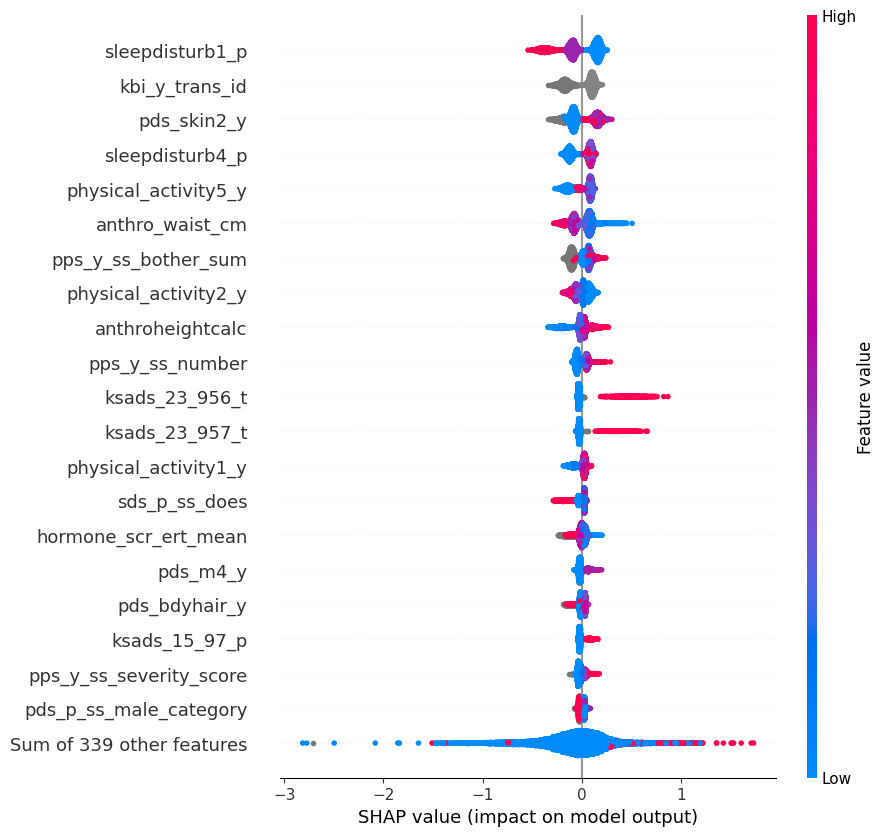

In [30]:
shap.plots.beeswarm(shap_values, max_display=21)

# SHAP dependence plots

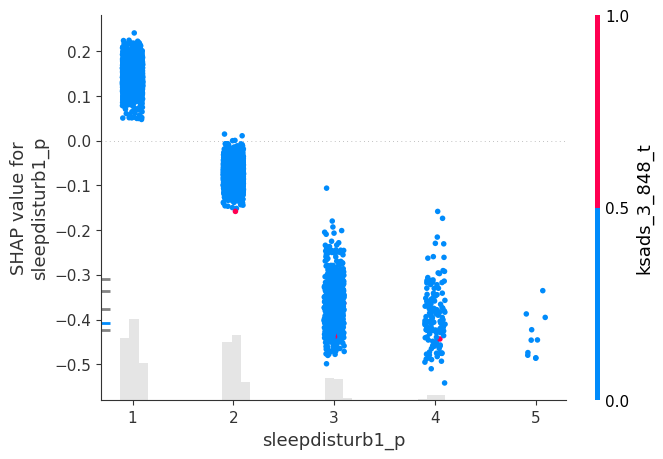

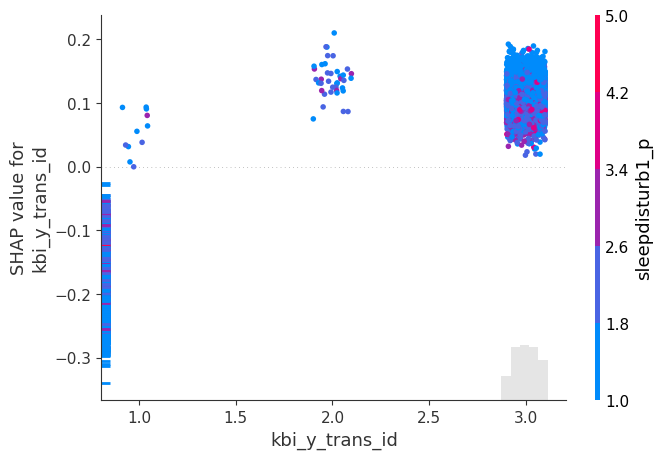

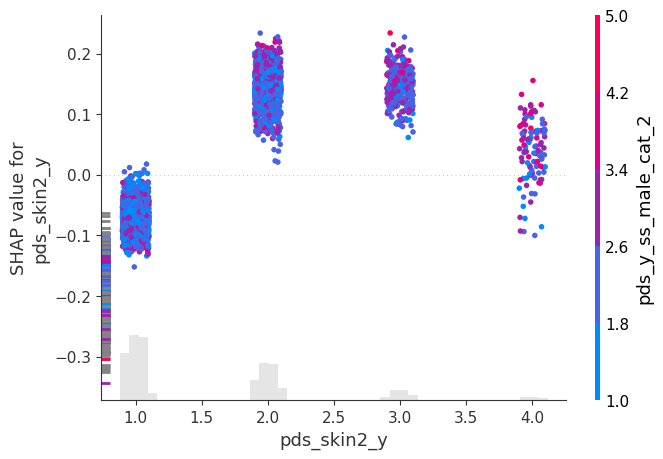

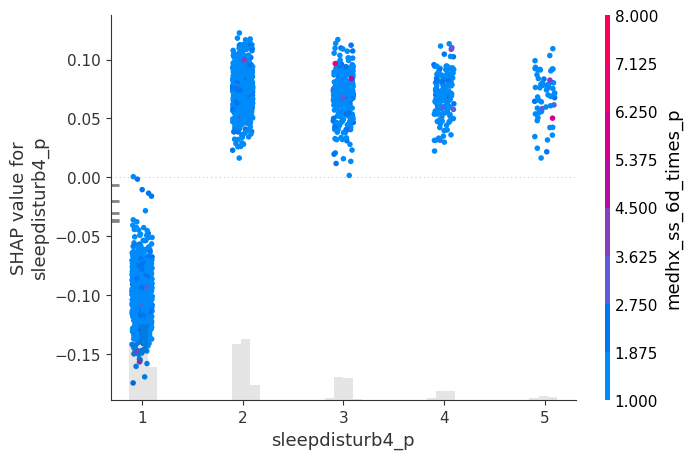

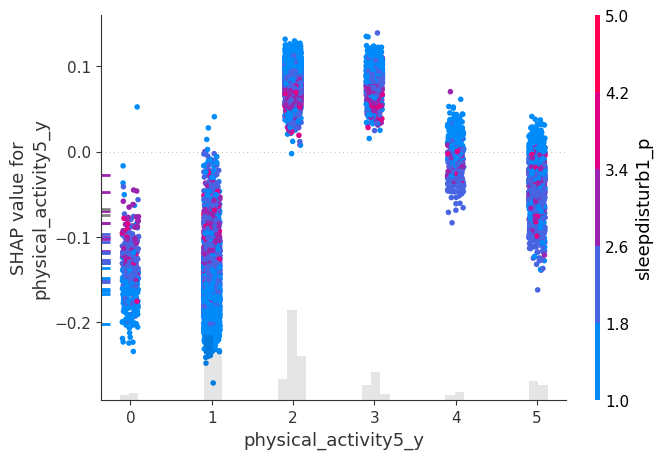

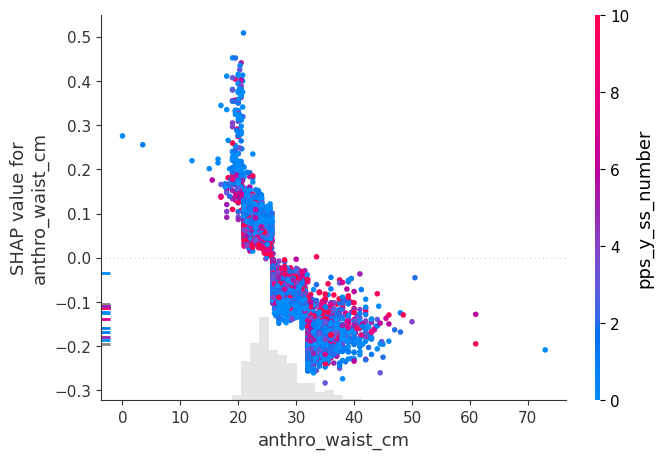

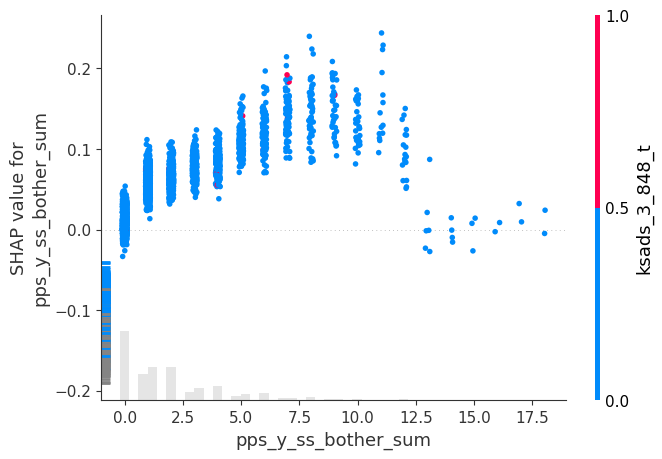

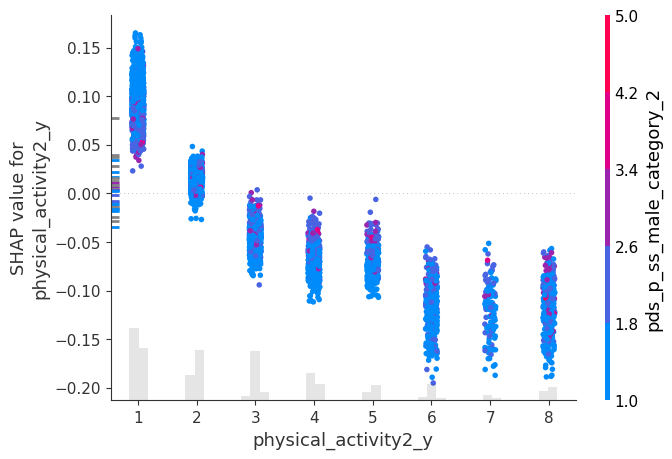

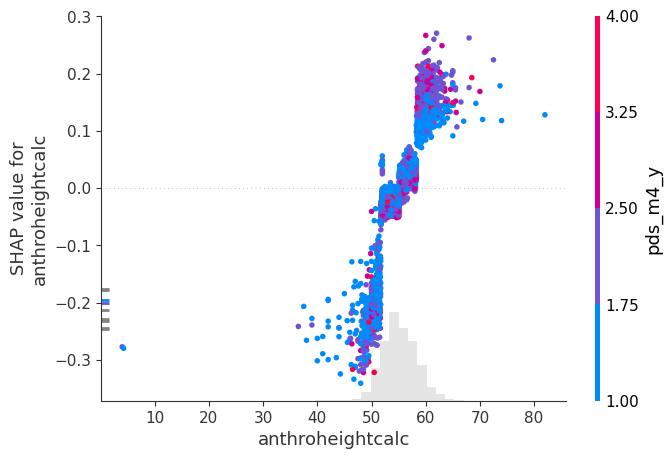

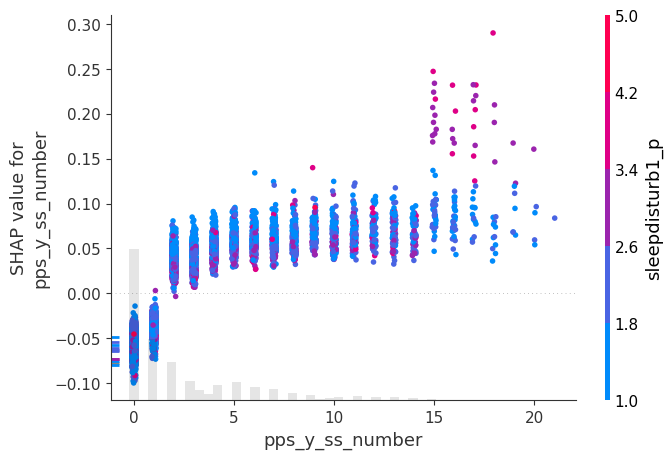

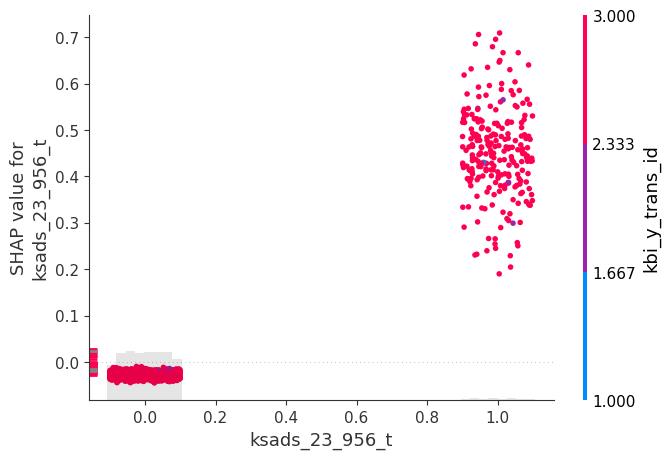

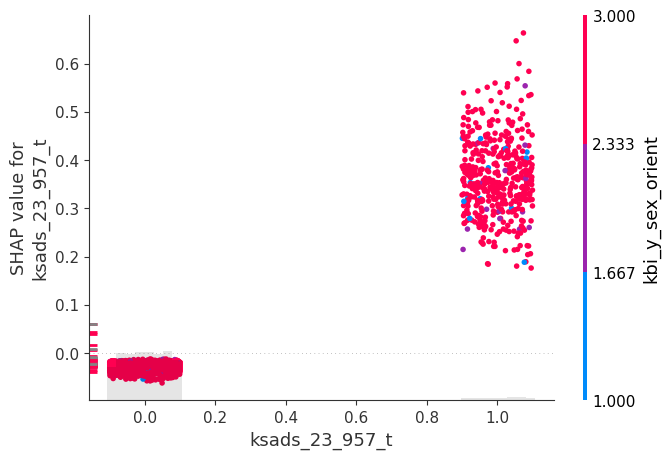

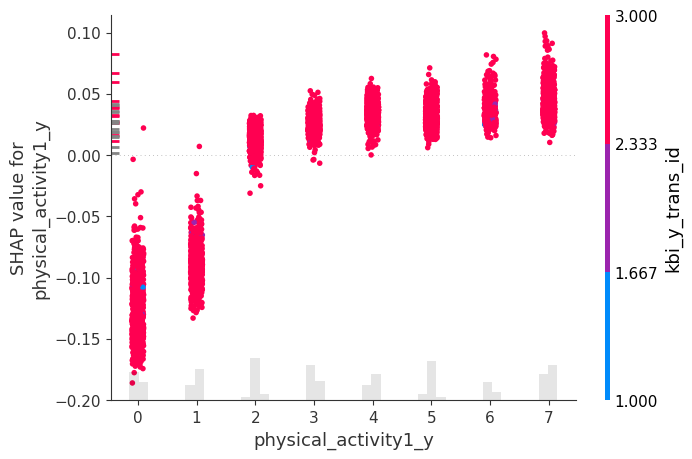

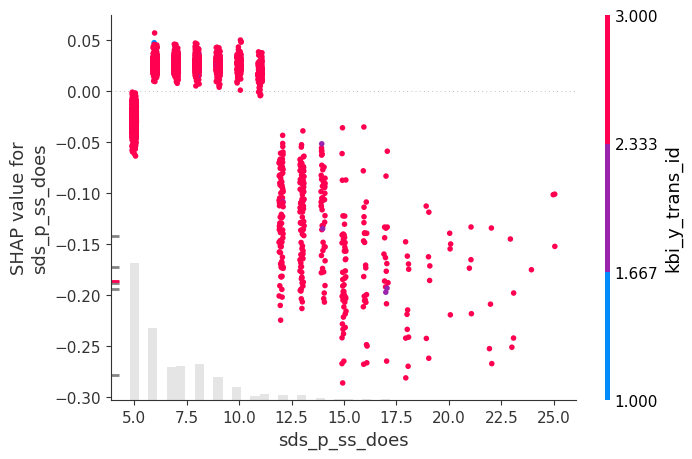

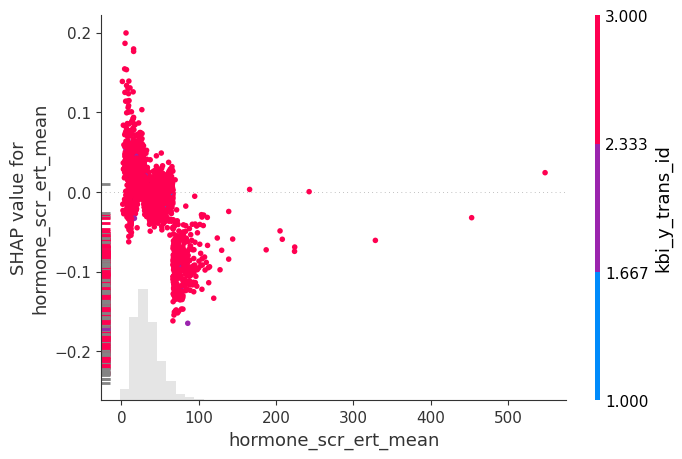

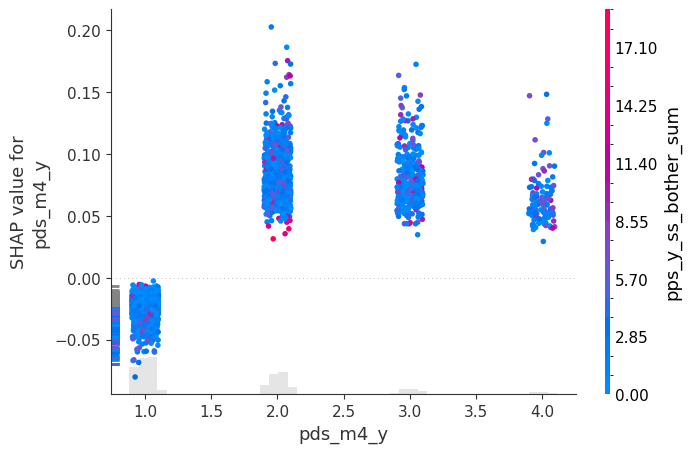

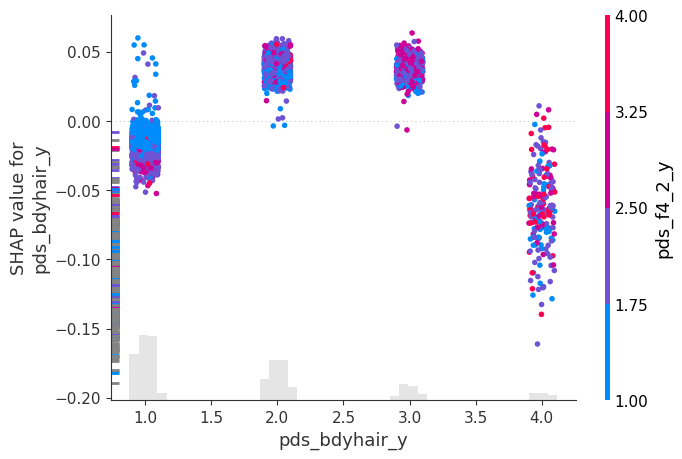

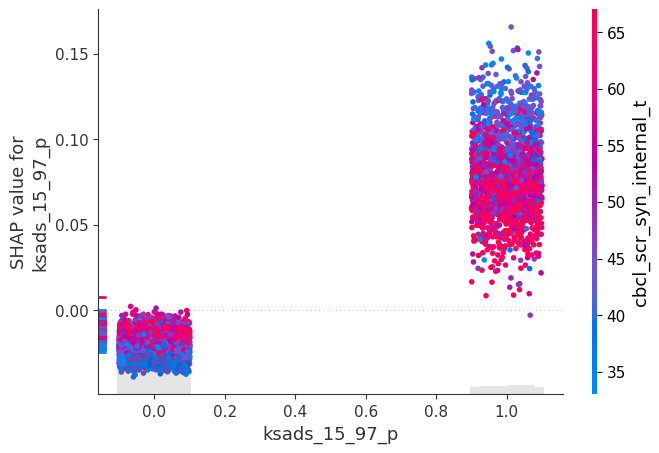

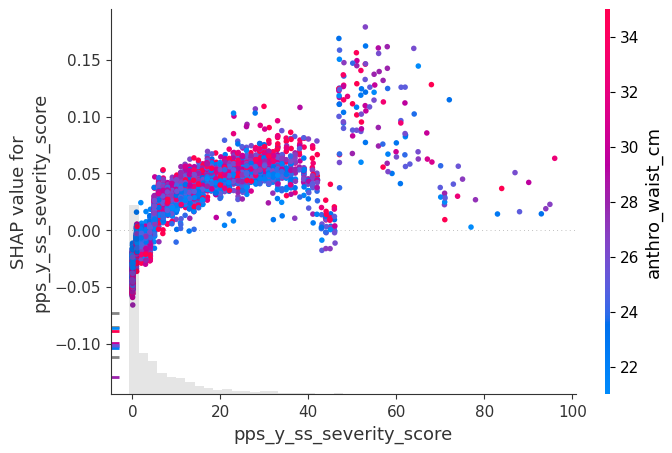

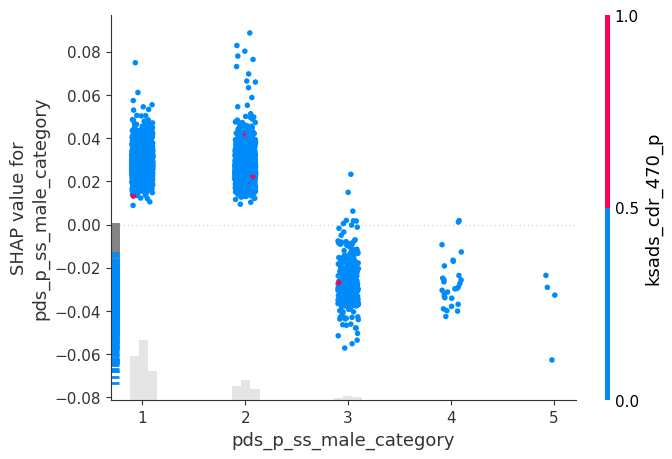

In [31]:
top_inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))
for i in range(20):
    shap.plots.scatter(shap_values[:, top_inds[i]], color=shap_values)